In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf,pacf

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings


warnings.filterwarnings("ignore")



In [2]:
data = pd.read_excel('Sales_Data.xlsx')
data

,Order Date,Sales
0,2015-01-01,14205.7070
1,2015-02-01,4519.8920
2,2015-03-01,55205.7970
3,2015-04-01,27906.8550
4,2015-05-01,23644.3030
5,2015-06-01,34322.9356
6,2015-07-01,33781.5430
7,2015-08-01,27117.5365
8,2015-09-01,81623.5268
9,2015-10-01,31453.3930


```
1. Descomposición de la Serie de Tiempo: Comienza descomponiendo la serie de
tiempo en sus componentes principales: tendencia, estacionalidad y residuos. Utiliza
métodos como el suavizamiento exponencial o la descomposición estacional para
comprender la estructura subyacente de los datos.

```


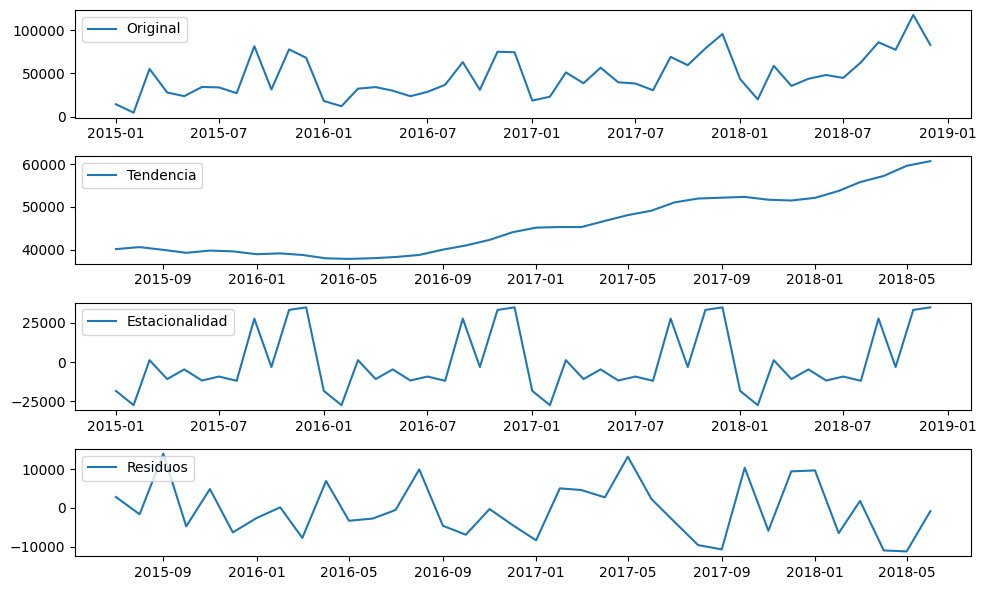

In [3]:
def decompose_time_series(data, column_name, model="additive"):
  
    # Realiza la descomposición estacional
    result = seasonal_decompose(data[column_name], model=model)

    # Grafica los componentes
    plt.figure(figsize=(10, 6))
    plt.subplot(411)
    plt.plot(data[column_name], label="Original")
    plt.legend(loc="upper left")
    plt.subplot(412)
    plt.plot(result.trend, label="Tendencia")
    plt.legend(loc="upper left")
    plt.subplot(413)
    plt.plot(result.seasonal, label="Estacionalidad")
    plt.legend(loc="upper left")
    plt.subplot(414)
    plt.plot(result.resid, label="Residuos")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

data["Order Date"] = pd.to_datetime(data["Order Date"])
data.set_index("Order Date", inplace=True)
decompose_time_series(data, column_name="Sales")

``` 
2. Identificación de Parámetros ARIMA: Utiliza las funciones de autocorrelación (ACF) y
autocorrelación parcial (PACF) para identificar los posibles valores de los parámetros
p (orden del término autorregresivo) y q (orden del término de media móvil) en el
modelo ARIMA. Además, realiza el test de Dickey-Fuller para determinar si es
necesario aplicar la diferenciación (valor d) para lograr la estacionaridad.

```

Estadística de prueba: -4.416136761430769
Valor p: 0.00027791039276670623
Valores críticos:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064
 Number of differencing needed: 0
La serie de tiempo es estacionaria.


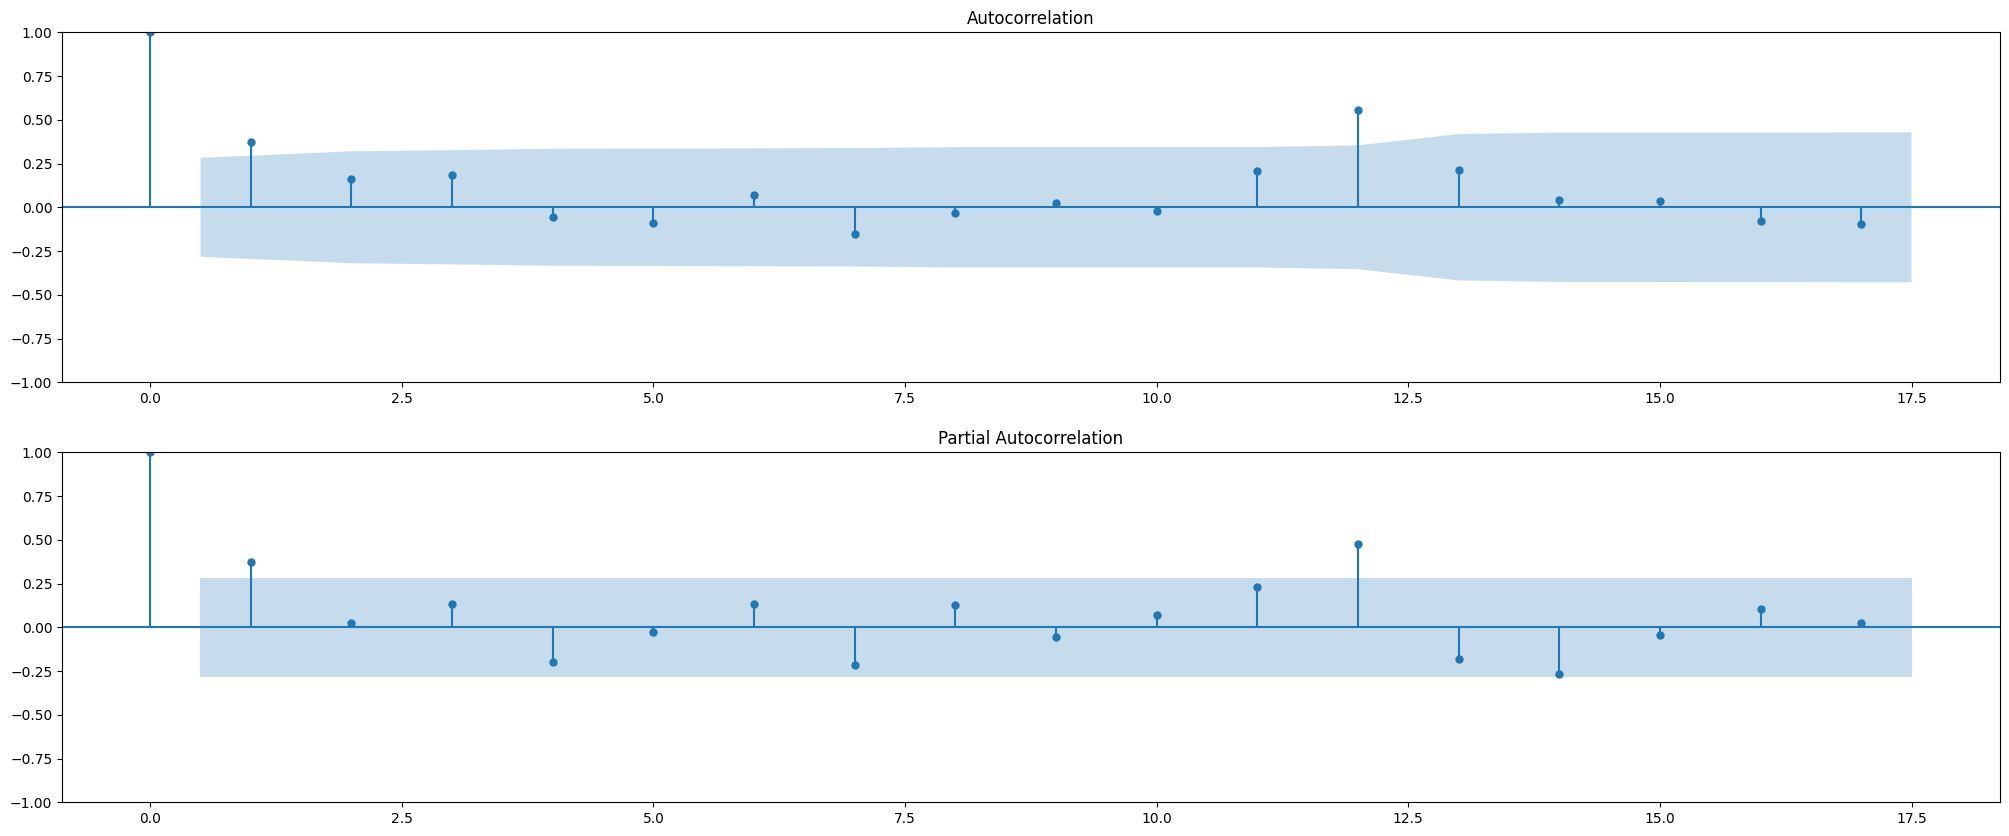

In [4]:
def identify_arima_parameters(data, column_name):

    # Realiza el test de Dickey-Fuller
    result = adfuller(data[column_name])
    diff_data = data[column_name]
    d = 0
    print("Estadística de prueba:", result[0])
    print("Valor p:", result[1])
    print("Valores críticos:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
        
        
    while result[1] > 0.05:
        diff_data = diff_data.diff()
        result[1] = adfuller(diff_data.dropna())[1]
        d += 1

    print(f" Number of differencing needed: {d}")

    # Si la serie no es estacionaria, aplica diferenciación
    if result[1] > 0.05:
        print("La serie de tiempo no es estacionaria.")
        print("Aplica diferenciación para lograr estacionariedad.")
    else:
        print("La serie de tiempo es estacionaria.")

    # Grafica las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF)
    fig, ax = plt.subplots(2, 1, figsize=(25, 10))
    plot_acf(diff_data, ax=ax[0])
    plot_pacf(diff_data, ax=ax[1])
    plt.show()
    
identify_arima_parameters(data, column_name="Sales")

In [5]:
p=7
d=0
q=14

``` 
3. Modelado con ARIMA: Aplica el modelo ARIMA utilizando los parámetros
identificados en el paso anterior. Ajusta el modelo a los datos históricos de ventas
mensuales y realiza predicciones para los próximos meses.
```

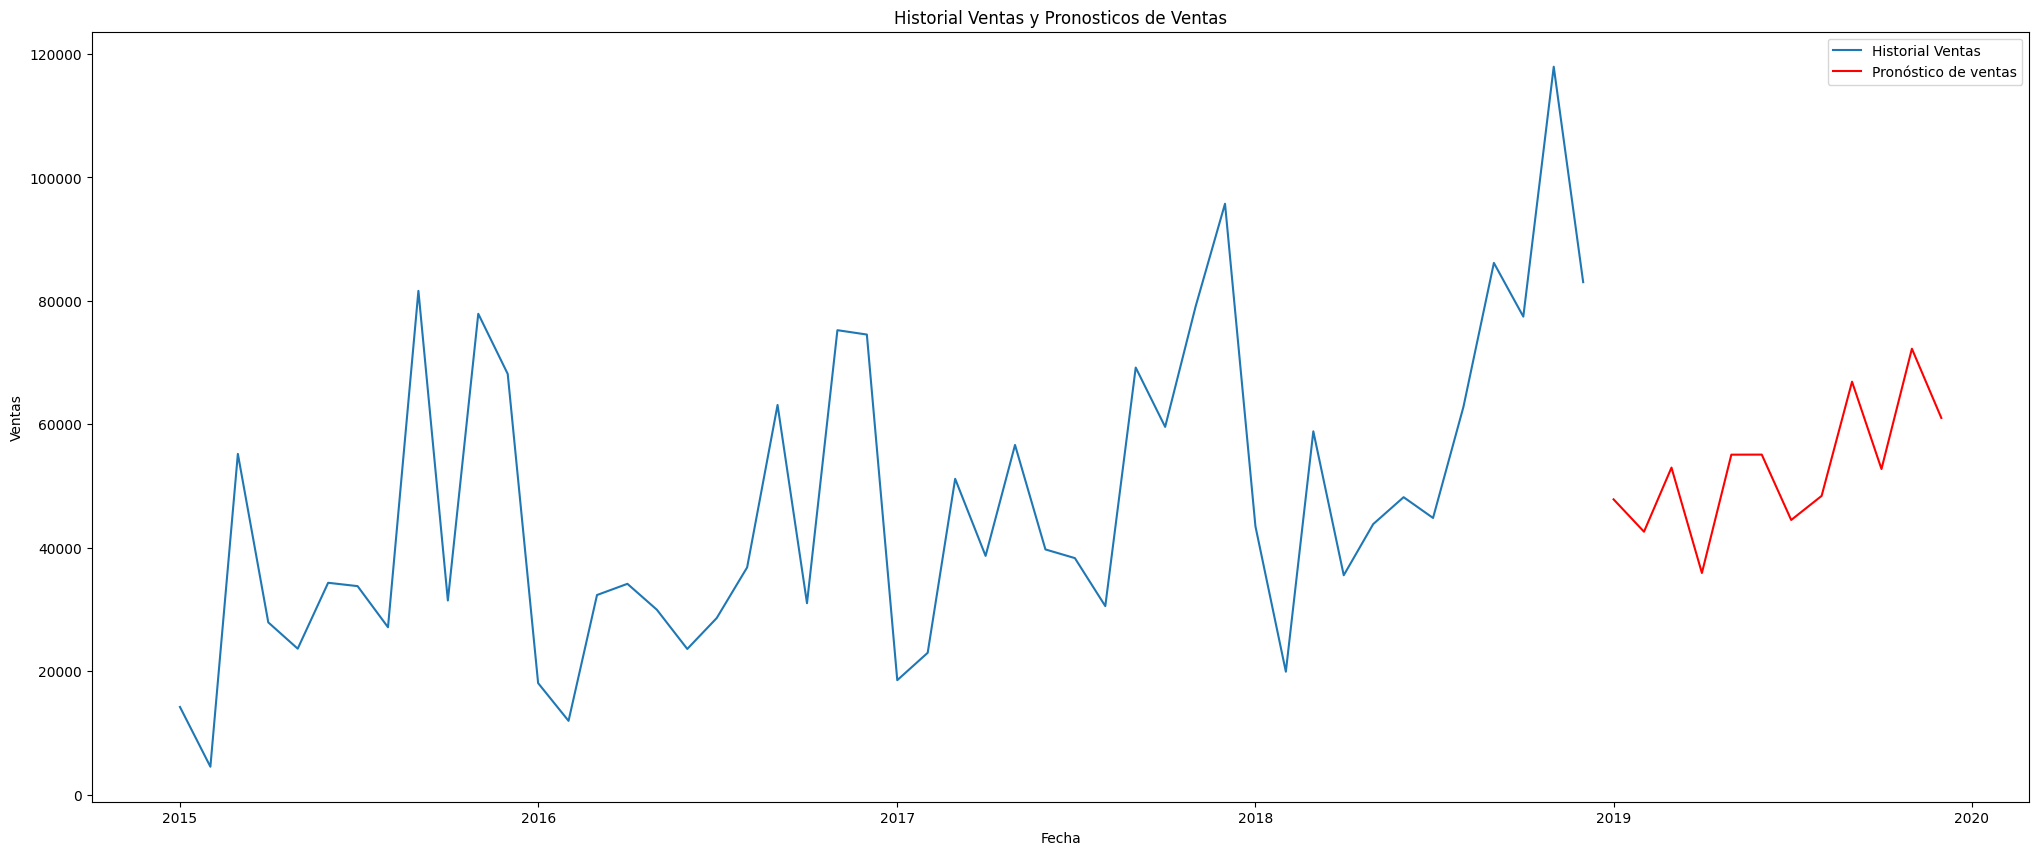

In [6]:
def fit_arima_model(data, column_name, p, d, q):
    # Ajustar el modelo ARIMA con los parámetros dados
    model = ARIMA(data[column_name], order=(p, d, q))
    results = model.fit()

    return results
arima_model = fit_arima_model(data, "Sales", p, d, q)

# Realizar predicciones para los próximos meses
forecast_steps = 12  # Número de pasos hacia adelante para predecir
forecast = arima_model.forecast(steps=forecast_steps)

# Crear un DataFrame para almacenar las predicciones
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq="MS")[1:]
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=["Sales Forecast"])

# Visualizar las predicciones
plt.figure(figsize=(25, 10))
plt.plot(data.index, data["Sales"], label="Historial Ventas")
plt.plot(forecast_index, forecast, label="Pronóstico de ventas", color="red")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.title("Historial Ventas y Pronosticos de Ventas")
plt.legend()
plt.show()


```
4. Evaluación de Predicciones: Divide los datos históricos en un conjunto de
entrenamiento y uno de prueba. Utiliza el conjunto de entrenamiento para ajustar el
modelo ARIMA y luego evalúa las predicciones en el conjunto de prueba. Calcula
métricas de evaluación como el error cuadrático medio (MSE) o el error absoluto
medio (MAE) para medir el rendimiento del modelo.
```


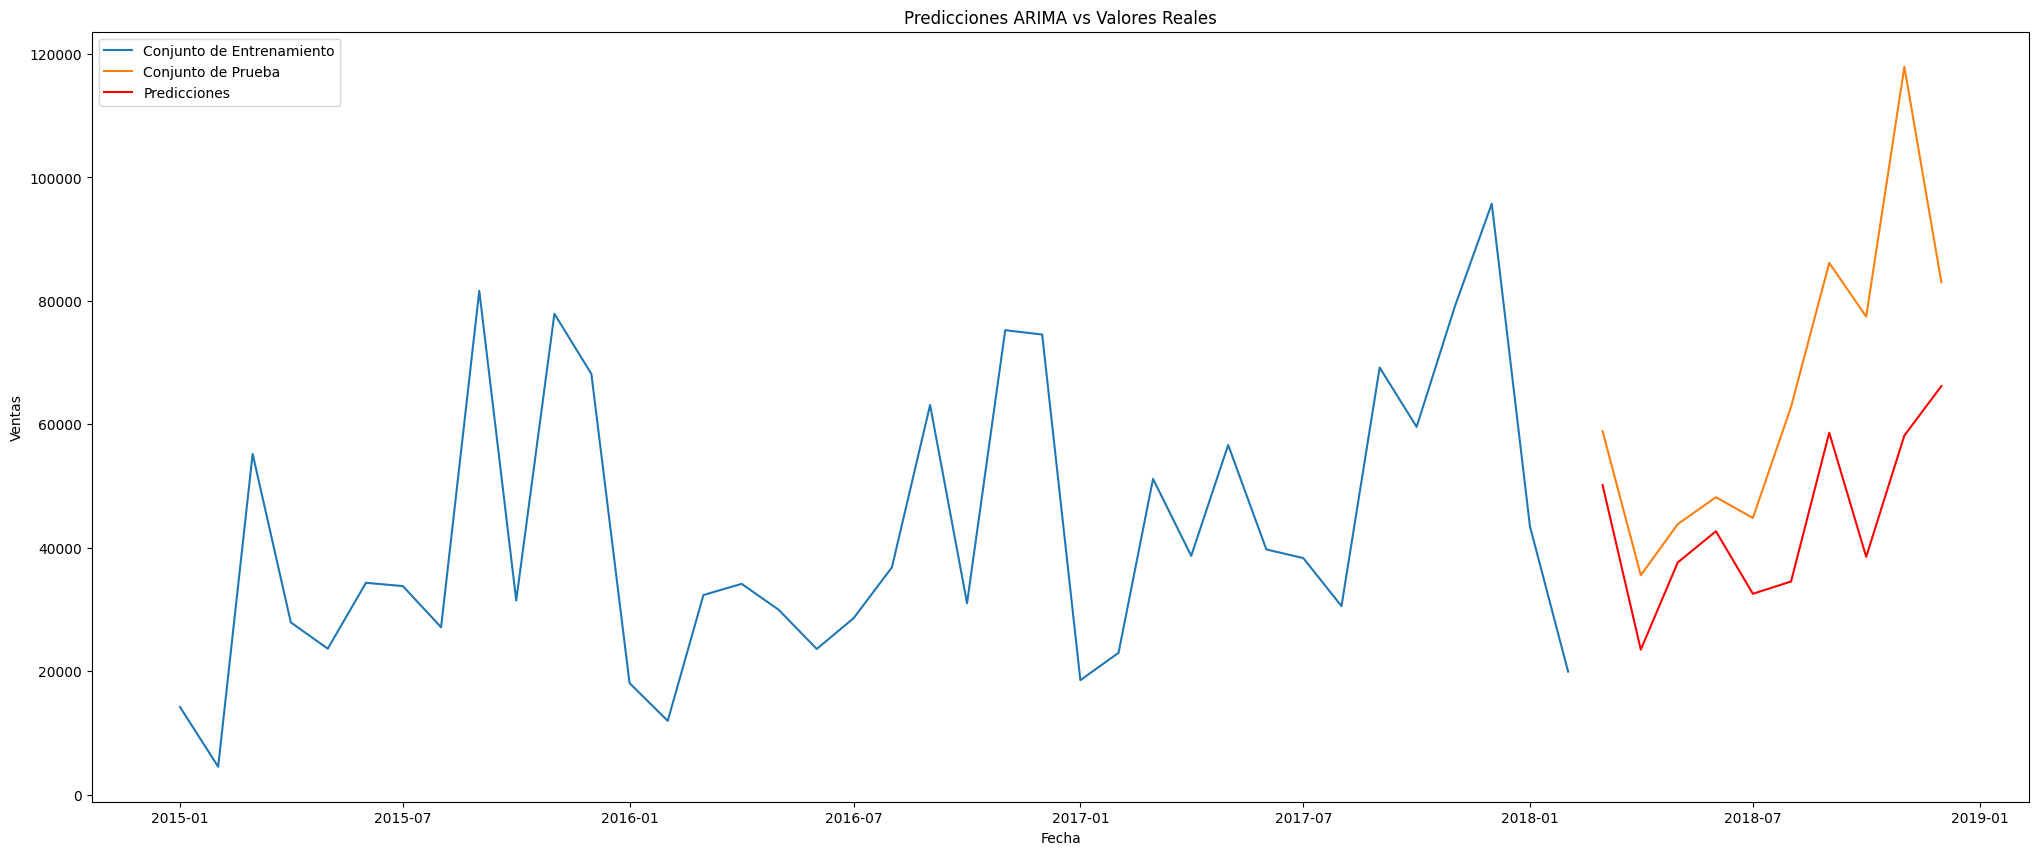

Error Cuadrático Medio (MSE): 736758972.8559443
Error Absoluto Medio (MAE): 21611.92152466303


In [7]:
def evaluate_arima_predictions(data, column_name, p, d, q, train_size=0.8):
    # Divide los datos en conjuntos de entrenamiento y prueba
    train_size = int(len(data) * train_size)
    train_data, test_data = data[:train_size], data[train_size:]

    # Ajusta el modelo ARIMA utilizando el conjunto de entrenamiento
    arima_model = fit_arima_model(train_data, column_name, p, d, q)

    # Realiza predicciones en el conjunto de prueba
    forecast_steps = len(test_data)
    forecast = arima_model.forecast(steps=forecast_steps)

    # Calcula las métricas de evaluación
    mse = mean_squared_error(test_data[column_name], forecast)
    mae = mean_absolute_error(test_data[column_name], forecast)

    # Visualiza las predicciones junto con los valores reales en el conjunto de prueba
    plt.figure(figsize=(25, 10))
    plt.plot(
        train_data.index, train_data[column_name], label="Conjunto de Entrenamiento"
    )
    plt.plot(test_data.index, test_data[column_name], label="Conjunto de Prueba")
    plt.plot(test_data.index, forecast, label="Predicciones", color="red")
    plt.xlabel("Fecha")
    plt.ylabel("Ventas")
    plt.title("Predicciones ARIMA vs Valores Reales")
    plt.legend()
    plt.show()

    print("Error Cuadrático Medio (MSE):", mse)
    print("Error Absoluto Medio (MAE):", mae)


# Uso de la función para evaluar las predicciones ARIMA
evaluate_arima_predictions(data, "Sales", p, d, q)

``` Auto_ARIMA```

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=928.679, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=886.339, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=913.500, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=884.930, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=883.514, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=885.491, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=882.460, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=880.567, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=879.994, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=881.264, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=912.065, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=875.162, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=872.991, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=873.210, 

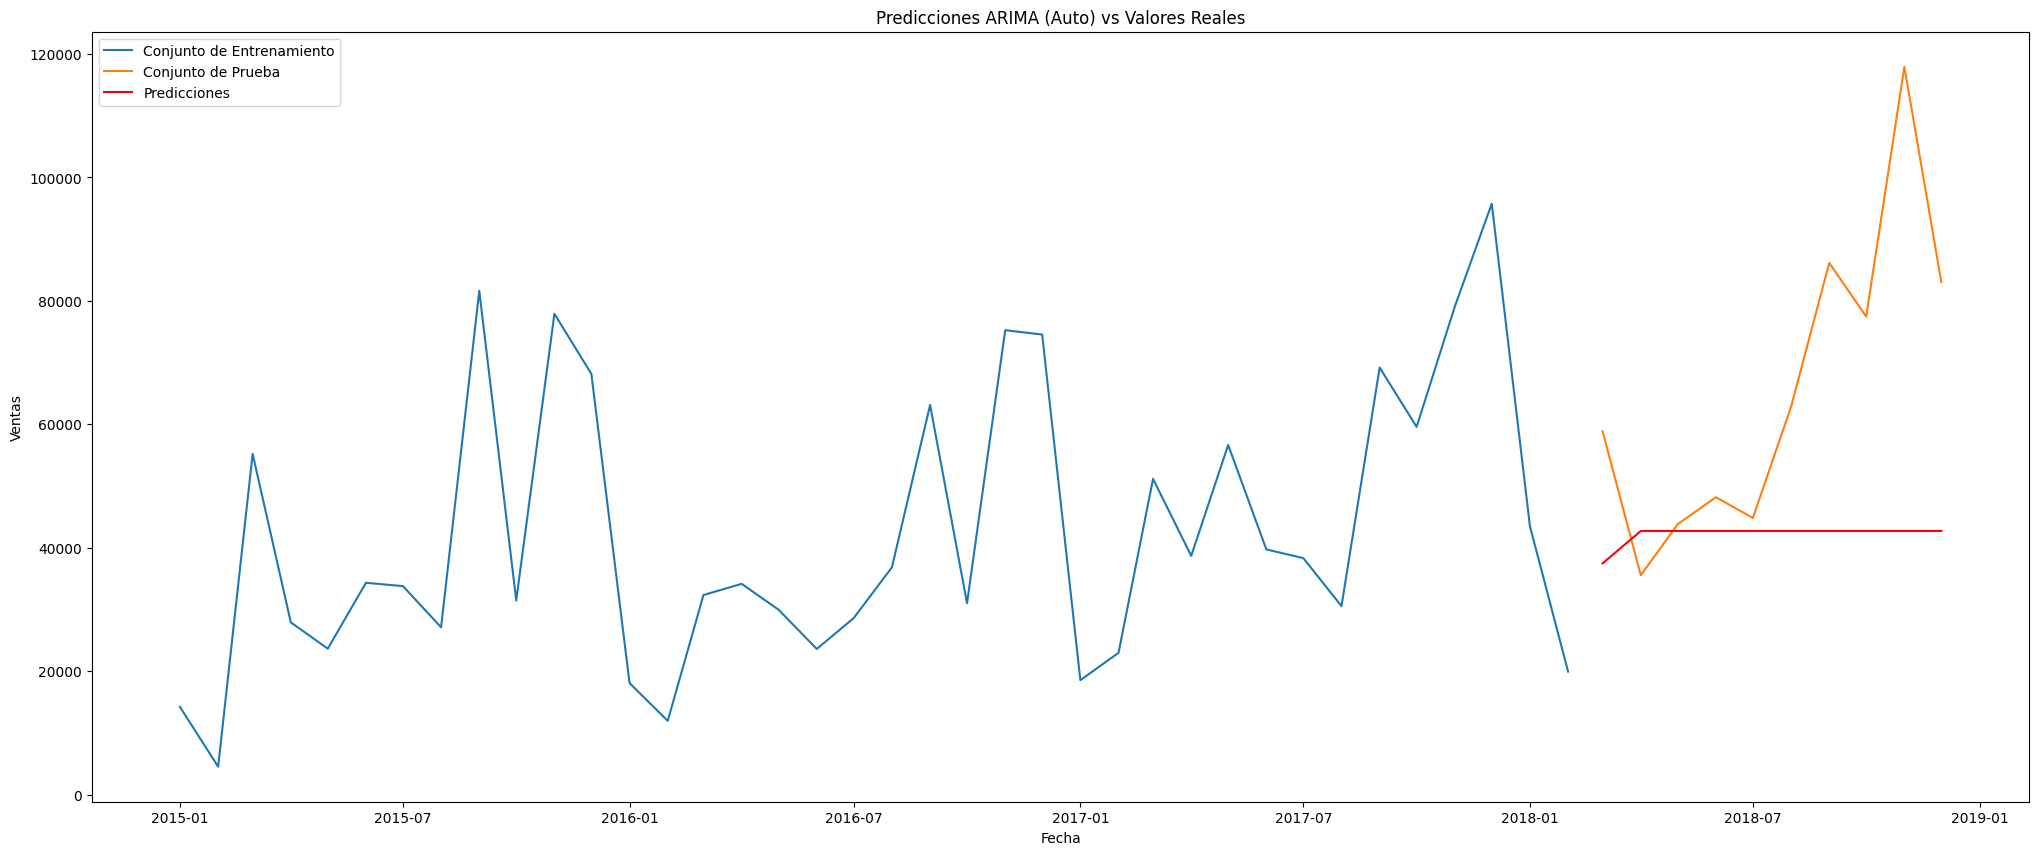

Error Cuadrático Medio (MSE): 1132640441.9065151
Error Absoluto Medio (MAE): 25108.77670416532


In [8]:
from pmdarima.arima import auto_arima

def evaluate_auto_arima_predictions(data, column_name, train_size=0.8):
    # Divide los datos en conjuntos de entrenamiento y prueba
    train_size = int(len(data) * train_size)
    train_data, test_data = data[:train_size], data[train_size:]
    
    # Ajusta el modelo ARIMA utilizando auto_arima
    arima_model = auto_arima(train_data[column_name], seasonal=False, trace=True)
    
    # Realiza predicciones en el conjunto de prueba
    forecast_steps = len(test_data)
    forecast = arima_model.predict(n_periods=forecast_steps)
    
    # Calcula las métricas de evaluación
    mse = mean_squared_error(test_data[column_name], forecast)
    mae = mean_absolute_error(test_data[column_name], forecast)
    
    # Visualiza las predicciones junto con los valores reales en el conjunto de prueba
    plt.figure(figsize=(25, 10))
    plt.plot(train_data.index, train_data[column_name], label="Conjunto de Entrenamiento")
    plt.plot(test_data.index, test_data[column_name], label="Conjunto de Prueba")
    plt.plot(test_data.index, forecast, label="Predicciones", color="red")
    plt.xlabel("Fecha")
    plt.ylabel("Ventas")
    plt.title("Predicciones ARIMA (Auto) vs Valores Reales")
    plt.legend()
    plt.show()
    
    print("Error Cuadrático Medio (MSE):", mse)
    print("Error Absoluto Medio (MAE):", mae)

# Uso de la función para evaluar las predicciones ARIMA con auto_arima
evaluate_auto_arima_predictions(data, "Sales")
